In [1]:
pip list | grep torch

torch                     2.8.0+cu128
torchinfo                 1.8.0
torchvision               0.23.0+cu128
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.8
NVIDIA GeForce RTX 5070


Simple 1D -> 1D CNN

In [3]:
import torch
from torch.utils.data import Dataset
from torch import FloatTensor

BATCH_SIZE = 1
INPUT_VEC_SIZE = 4 # how many columns per row
OUTPUT_VEC_SIZE_GV = 2001 # global view output vector size

# relu for hidden
# sigmoid for output

class TabularDataset(Dataset):

    def __init__(self, X:FloatTensor, Y:FloatTensor):
        """
        X: tensor with shape of (BATCH_SIZE, INPUT_VEC_SIZE)
        Y: tensor with shape of (BATCH_SIZE, OUTPUT_VEC_SIZE_GV)
        """

        self.X:FloatTensor = X 
        self.Y:FloatTensor = Y

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, i):
        x = self.X[i].unsqueeze(0)
        if self.Y is None: return x
        return x, self.Y[i]


    

In [4]:
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, Y, hidden=64, kernel_size=1):
        super().__init__()
        pad = kernel_size // 2
        
        self.features = nn.Sequential(
            nn.Conv1d(1, hidden, kernel_size=kernel_size, padding=pad),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=kernel_size, padding=pad),
            nn.ReLU(),
        )

        self.resize = nn.AdaptiveAvgPool1d(Y)
        self.head = nn.Conv1d(hidden, 1, kernel_size=1)

    def forward(self, x):
        z = self.features(x)
        z = self.resize(z)
        z = self.head(z)
        out = z.squeeze(1)
        return out

In [5]:
from torch.utils.data import DataLoader

# assemble fake data for testing

fake_input = torch.randn(BATCH_SIZE, INPUT_VEC_SIZE)
fake_targets = torch.randn(BATCH_SIZE, OUTPUT_VEC_SIZE_GV)

loader = DataLoader(TabularDataset(fake_input, fake_targets), batch_size=2, shuffle=False)


In [6]:
model = CNN1D(Y=OUTPUT_VEC_SIZE_GV, hidden=16, kernel_size=1)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr =1e-3)

In [7]:
for xb, yb in loader:
    pred = model(xb)                 # prints shapes
    loss = criterion(pred, yb)
    print("loss   :", loss.item())

    opt.zero_grad()
    loss.backward()                  # autograd computes grads
    opt.step()
    print("--- batch done ---\n")

loss   : 1.0506465435028076
--- batch done ---



In [8]:
print(model)  # textual architecture

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"params: total={total:,} trainable={trainable:,}")


CNN1D(
  (features): Sequential(
    (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (resize): AdaptiveAvgPool1d(output_size=2001)
  (head): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
)
params: total=321 trainable=321


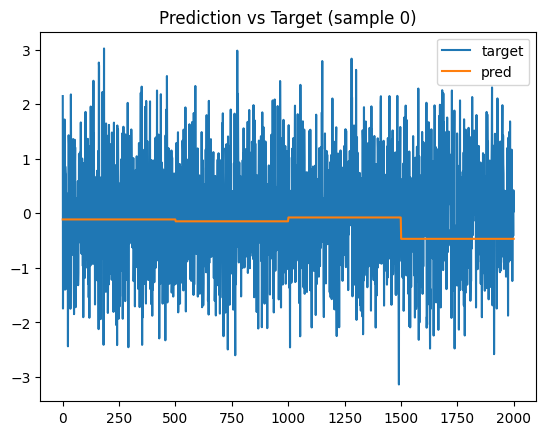

In [9]:
import torch
import matplotlib.pyplot as plt

model.eval()
xb, yb = next(iter(loader))                # xb: (B,1,X), yb: (B,Y)
with torch.no_grad():
    pred = model(xb)                       # (B,Y)

i = 0  # which sample to view
plt.figure()
plt.plot(yb[i].numpy(), label="target")
plt.plot(pred[i].numpy(), label="pred")
plt.legend()
plt.title("Prediction vs Target (sample 0)")
plt.show()


In [10]:
from torchinfo import summary
summary(model, input_size=(2,1,INPUT_VEC_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [2, 2001]                 --
├─Sequential: 1-1                        [2, 16, 4]                --
│    └─Conv1d: 2-1                       [2, 16, 4]                32
│    └─ReLU: 2-2                         [2, 16, 4]                --
│    └─Conv1d: 2-3                       [2, 16, 4]                272
│    └─ReLU: 2-4                         [2, 16, 4]                --
├─AdaptiveAvgPool1d: 1-2                 [2, 16, 2001]             --
├─Conv1d: 1-3                            [2, 1, 2001]              17
Total params: 321
Trainable params: 321
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04